In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Resample

import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

## FÖR ATT ÅTERSKAPA: test_output = Resample(resample_rate,48000)(next(iter(dataset)))
## FÖR ATT SPARA: torchaudio.save("./test_output.wav",test_output.unsqueeze(0),48000)


class MP3Dataset(Dataset):
    def __init__(self, file_paths, resample_rate):
        self.file_paths = file_paths
        self.resample_rate = resample_rate
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.file_paths[idx],normalize=True)
        #waveform = librosa.util.normalize(waveform)

        waveform = torch.Tensor(waveform)#.unsqueeze(0)
        waveform = Resample(sample_rate, self.resample_rate)(waveform)
        waveform = waveform.to(device)
        return waveform


train_dir = "./train_data/"
train_paths = [f for f in os.listdir(train_dir) if f.endswith(".mp3")]
train_paths = [os.path.join(train_dir, x) for x in train_paths]
train_paths = train_paths[0:(len(train_paths)//5)] # Reduced training set by a factor 20.
print(len(train_paths))

val_dir = "./val_data/"
val_paths = [f for f in os.listdir(val_dir) if f.endswith(".mp3")]
val_paths = [os.path.join(val_dir, x) for x in val_paths]
val_paths = val_paths[0:32]

#train_paths = ["./train_data/chunk_1.mp3"]
#val_paths = ["./train_data/chunk_1.mp3"]


resample_rate = 4000
train_dataset = MP3Dataset(train_paths,resample_rate)
val_dataset = MP3Dataset(val_paths,resample_rate)
train = DataLoader(train_dataset, batch_size=2, shuffle=True)
val = DataLoader(val_dataset, batch_size = 16, shuffle = True)




cpu


In [4]:
torchaudio.load('./output_chunks/chunk_1.mp3')
print(torchaudio.info('./output_chunks/chunk_1.mp3'))

AudioMetaData(sample_rate=48000, num_frames=720000, num_channels=2, bits_per_sample=0, encoding=MP3)


In [7]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        
        self.input_size = input_size
        self.latent_size = latent_size
        
        
        self.kernel_size = 16
        channels = 128
        self.encoder = nn.Sequential(
            nn.Conv1d(2, channels, kernel_size=self.kernel_size, stride=4, padding=0),
            nn.BatchNorm1d(channels),
            nn.ReLU(),
            
            nn.Conv1d(channels, channels, kernel_size=self.kernel_size, stride=4, padding=0),
            nn.BatchNorm1d(channels),
            nn.ReLU(),
            
            nn.Conv1d(channels, channels, kernel_size=self.kernel_size, stride=4, padding=0),
            nn.BatchNorm1d(channels),
            nn.ReLU(),
            
            nn.Conv1d(channels, channels, kernel_size=self.kernel_size, stride=4, padding=1),
            nn.BatchNorm1d(channels),
            nn.ReLU(),
        )        
        self.flatten = nn.Flatten(1)
        
        flat_size = self._infer_flat_size()
        #print(flat_size)
        self.enc_mu = nn.Sequential(nn.Linear(flat_size, self.latent_size))#,nn.Linear(256,100))
        self.enc_logvar = nn.Sequential(nn.Linear(flat_size, self.latent_size))#,nn.Linear(256,100))
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size,flat_size),
            nn.Unflatten(1,(channels,int(flat_size/channels))),
            
            nn.ConvTranspose1d(channels, channels, kernel_size=self.kernel_size, stride=4,padding=1,output_padding=3),
            nn.BatchNorm1d(channels),
            nn.ReLU(),
            
            nn.ConvTranspose1d(channels, channels, kernel_size=self.kernel_size, stride=4,output_padding = 2),
            nn.BatchNorm1d(channels),
            nn.ReLU(),
            
            nn.ConvTranspose1d(channels, channels, kernel_size=self.kernel_size, stride=4,padding = 0, output_padding = 1),
            nn.BatchNorm1d(channels),
            nn.ReLU(),
            
            nn.ConvTranspose1d(channels, 2, kernel_size=self.kernel_size, stride=4, padding=0,output_padding=0),
    
            #nn.Tanh()
        )
        # Decoder
        #self.fc3 = nn.Linear(latent_size, hidden_size)
        #self.fc4 = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        encoder_output = self.encoder(x)
        encoder_output = self.flatten(encoder_output)
        return self.enc_mu(encoder_output), self.enc_logvar(encoder_output)
    
    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def decode(self, z):
        decoder_output = self.decoder(z)
        return decoder_output

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def _infer_flat_size(self):
        flat_size = self.encoder(torch.ones(1, *self.input_size))
        flat_size = self.flatten(flat_size)
        
        return flat_size.shape[1]

# Reconstruction + KL divergence losses summed over all elements and batch
class loss_function(nn.Module):
    def __init__(self):
        super(loss_function,self).__init__()

    def forward(self, recon_x, x, mu, logvar):
        MSE = F.l1_loss(recon_x,x) * 10
        
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

        #KLD = - 0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar))
        #print(KLD.shape)

        KLD = - 0.5 * torch.sum(1 + logvar - (torch.pow(mu, 2) + torch.exp(logvar)))
        KLD = KLD*1e-5
        
        #MSE + KLD, MSE.detach().to('cpu'), KLD.detach().to('cpu')

        return MSE + KLD, MSE.detach().to('cpu'), KLD.detach().to('cpu')

# Initialize the VAE
input_size = (2,resample_rate*15)
hidden_size = 400
latent_size = 200

vae = VAE(input_size, hidden_size, latent_size)
vae.to(device)

# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3) # 1e-5 seems good
VAEloss = loss_function()


#input_size = resample_rate*15 # 15s per sample
print(f"output size should be {resample_rate*15}")
summary(vae,input_size=[64,*input_size])

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [64, 2, 120000]           --
├─Sequential: 1-1                        [64, 32, 28]              --
│    └─Conv1d: 2-1                       [64, 32, 119992]          608
│    └─BatchNorm1d: 2-2                  [64, 32, 119992]          64
│    └─ReLU: 2-3                         [64, 32, 119992]          --
│    └─Conv1d: 2-4                       [64, 32, 29996]           9,248
│    └─BatchNorm1d: 2-5                  [64, 32, 29996]           64
│    └─ReLU: 2-6                         [64, 32, 29996]           --
│    └─Conv1d: 2-7                       [64, 32, 7497]            9,248
│    └─BatchNorm1d: 2-8                  [64, 32, 7497]            64
│    └─ReLU: 2-9                         [64, 32, 7497]            --
│    └─Conv1d: 2-10                      [64, 32, 1873]            9,248
│    └─BatchNorm1d: 2-11                 [64, 32, 1873]            64
│    

In [ ]:
load_model = False
if load_model:
    vae.load_state_dict(torch.load('model_1500epochs_increment1.pth'))

In [30]:
## Training Loop

print(device)
vae.train()

print(next(vae.parameters()).device)
vae.to(device)
print(next(vae.parameters()).device)



train_avg_losses = [[],[],[]] 
val_avg_losses = [[],[],[]]
####
optimizer = optim.Adam(vae.parameters(), lr=2e-5)
####
n_epochs = 20000



start_time = time.time()
for epoch in range(n_epochs):
    print(f"###### epoch: {epoch} ######")
    
    train_loss = []
    recon_loss = []
    KLD_loss = []
    
    if epoch % 20 == 0:    
        val_loss = []
        val_recon_loss = []
        val_KLD_loss = []
        
        for batch in val:
           
            vae.eval()
            
            batch.to(device)
            decoded, mu, logvar = vae(batch)
            
            val_losses = VAEloss(decoded,batch,mu,logvar)
            val_batch_loss = val_losses[0]

            val_loss.append(val_batch_loss.detach().to('cpu'))
            val_recon_loss.append(val_losses[1])
            val_KLD_loss.append(val_losses[2])
            
            vae.train()
        print(f"***\n### Average Val loss: {np.mean(val_loss)}\n***")    
        print(f"### Time since start: {time.time() - start_time}\t Time per epoch: {(time.time()-start_time)/(epoch +1)}")
    
    

    for batch in train:
        batch.to(device)
        decoded, mu, logvar = vae(batch)
        
        losses = VAEloss(decoded,batch,mu,logvar)
        #losses = VAEloss(decoded.to(device), batch.to(device), mu.to(device), logvar.to(device))

        loss = losses[0]
        
        train_loss.append(loss.detach().to('cpu'))
        recon_loss.append(losses[1])
        KLD_loss.append(losses[2])
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #print("loss: ", loss.item())
    
    
    train_avg_losses[0].append(np.mean(train_loss))
    train_avg_losses[1].append(np.mean(recon_loss))
    train_avg_losses[2].append(np.mean(KLD_loss))
    
    val_avg_losses[0].append(np.mean(val_loss))
    val_avg_losses[1].append(np.mean(val_recon_loss))
    val_avg_losses[2].append(np.mean(val_KLD_loss))
    
    print(f"### Batch Avg loss: {train_avg_losses[0][-1]}, recon avg: {train_avg_losses[1][-1]}, KLD avg:{train_avg_losses[2][-1]}")
        
        
        

mps
cpu
mps:0
epoch: 0
loss:  0.24641068279743195
loss:  0.25560107827186584
loss:  0.25164222717285156
loss:  0.23763678967952728
loss:  0.2492736577987671
loss:  0.24438786506652832
loss:  0.2527411878108978
loss:  0.24834522604942322
loss:  0.25083452463150024
loss:  0.25258827209472656
loss:  0.24913302063941956
loss:  0.23970088362693787
loss:  0.24264156818389893
loss:  0.24802014231681824
loss:  0.24565830826759338
loss:  0.2496212124824524
loss:  0.24146150052547455
loss:  0.23865605890750885
loss:  0.2500123977661133
loss:  0.24042515456676483
loss:  0.2464301437139511
loss:  0.2424229383468628
loss:  0.24730029702186584
loss:  0.2402859330177307
loss:  0.2425159215927124
loss:  0.24018368124961853
loss:  0.24393200874328613
loss:  0.24353976547718048
loss:  0.23569747805595398
loss:  0.24148356914520264
epoch: 1
loss:  0.2386813908815384
loss:  0.2422274351119995
loss:  0.24561236798763275
loss:  0.24621707201004028
loss:  0.2414727807044983
loss:  0.24392186105251312
loss:  

KeyboardInterrupt: 

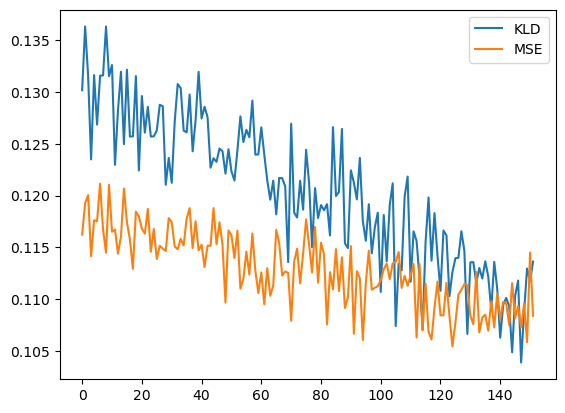

In [31]:
import matplotlib.pyplot as plt

bins = range(0,len(train_avg_losses[0]))

plt.plot(bins,train_avg_losses[1], label="MSE")
plt.yscale('log')
plt.plot(bins,train_avg_losses[2], label="KLD")


plt.plot(bins,val_avg_losses[1], label="VAL_MSE")
plt.plot(bins,val_avg_losses[2], label="VAL_KLD")
plt.legend()


In [6]:
### Saving the training and val losses:
import pickle

with open(f'train_avg_losses_1500epochs_incr2.pkl', 'wb') as f:
            pickle.dump(train_avg_losses, f)

with open(f'val_avg_losses_1500epochs_incr2.pkl', 'wb') as f:
            pickle.dump(train_avg_losses, f)

[tensor(0.0735), tensor(0.0742), tensor(0.0697), tensor(0.0709), tensor(0.0711), tensor(0.0708), tensor(0.0753), tensor(0.0730), tensor(0.0725), tensor(0.0715), tensor(0.0704), tensor(0.0729), tensor(0.0744), tensor(0.0736), tensor(0.0717), tensor(0.0734), tensor(0.0720), tensor(0.0707), tensor(0.0727), tensor(0.0727), tensor(0.0709), tensor(0.0715), tensor(0.0755), tensor(0.0741), tensor(0.0697), tensor(0.0723), tensor(0.0719), tensor(0.0721), tensor(0.0723), tensor(0.0744), tensor(0.0733), tensor(0.0723), tensor(0.0736), tensor(0.0712), tensor(0.0718), tensor(0.0730), tensor(0.0734), tensor(0.0675), tensor(0.0751), tensor(0.0720), tensor(0.0715), tensor(0.0733), tensor(0.0723), tensor(0.0692), tensor(0.0747), tensor(0.0701), tensor(0.0691), tensor(0.0707), tensor(0.0703), tensor(0.0693), tensor(0.0702), tensor(0.0747), tensor(0.0718), tensor(0.0694), tensor(0.0698), tensor(0.0684), tensor(0.0716), tensor(0.0693), tensor(0.0717), tensor(0.0688), tensor(0.0753), tensor(0.0715), tensor(

In [25]:
torch.save(vae.state_dict(), './model_1500epochs_increment2.pth')

In [32]:
model = vae.eval().to('cpu')

plot_rate = 48000


test_output = (next(iter(train)))[0]
test_output = test_output.unsqueeze(0).to('cpu')

compare_output = Resample(resample_rate,plot_rate)(test_output.squeeze())
torchaudio.save("./compare_output.wav",compare_output,plot_rate)

test_output = model(test_output)[0]
test_output = test_output.squeeze(0)
print(test_output.shape)


test_output = Resample(resample_rate,plot_rate)(test_output)
torchaudio.save("./test_output.wav",test_output,plot_rate)


torch.Size([2, 120000])


In [28]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Generate example data
samples = plot_rate*15
time_series = test_output.detach()[:resample_rate]

# Compute FFT
fft_values = np.fft.fft(time_series) + 1
fft_freq = np.fft.fftfreq(samples)*100000

# Plot the results
plt.figure(figsize=(10, 6))

# Plot for the first channel
plt.subplot(2, 1, 1)
plt.plot(fft_freq[:(len(fft_freq)//2)], np.abs(fft_values[0])[:(len(fft_freq)//2)])
plt.title('FFT - Channel 1')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Amplitude')

# Plot for the second channel
plt.subplot(2, 1, 2)
plt.plot(fft_freq[:(len(fft_freq)//2)], np.abs(fft_values[0])[:(len(fft_freq)//2)])
plt.title('FFT - Channel 1')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()



torch.Size([2, 120000])


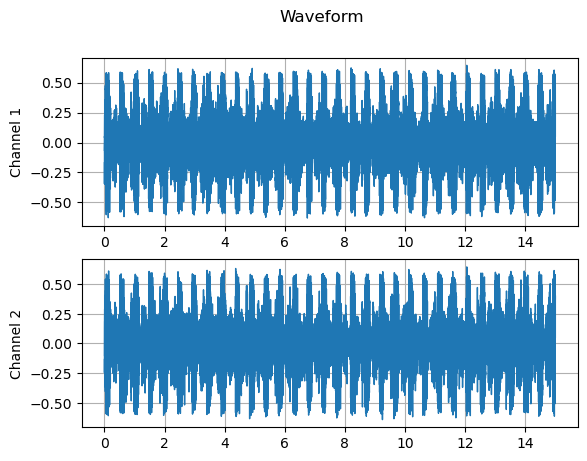

In [7]:
plot_waveform(compare_output,sample_rate=48000)

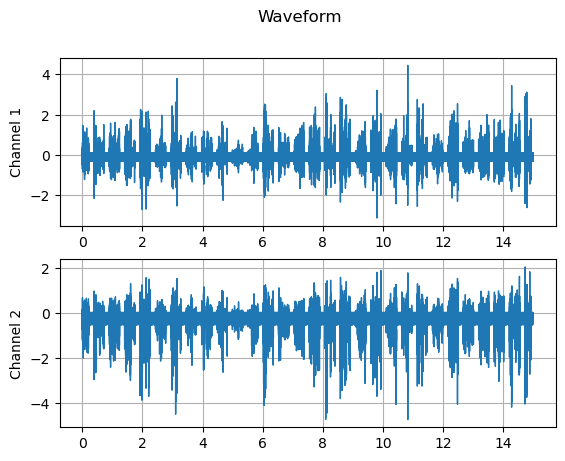

In [29]:
plot_waveform(test_output.detach(),sample_rate=48000)